In [16]:
import os
os.listdir()


['.config',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'calendar.csv',
 'sample_data']

# Phase B — M5 Demand Forecasting (Walmart)

Goal:
Build an industry-grade demand forecasting system using Walmart sales data (M5).

Key Focus:
- Scale (multiple SKUs & stores)
- Seasonality & hierarchy
- Model comparison (Naive, SARIMA, Prophet later)
- Business impact & production thinking


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sales = pd.read_csv("sales_train_validation.csv")
calendar = pd.read_csv("calendar.csv")
prices = pd.read_csv("sell_prices.csv")

print(sales.shape, calendar.shape, prices.shape)


(30490, 1919) (1969, 14) (6841121, 4)


In [18]:
print("Sales:", sales.shape)
print("Calendar:", calendar.shape)
print("Prices:", prices.shape)


Sales: (30490, 1919)
Calendar: (1969, 14)
Prices: (6841121, 4)


In [19]:
sales.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [20]:
sales[['id','item_id','dept_id','cat_id','store_id','state_id']].head()


,id,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA


In [21]:
subset_sales = sales[
    (sales['state_id'] == 'CA') &
    (sales['store_id'] == 'CA_1')
].head(10)

subset_sales.shape


(10, 1919)

In [22]:
sales_long = subset_sales.melt(
    id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
    var_name='d',
    value_name='demand'
)

sales_long.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [23]:
calendar.head()


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [24]:
sales_long = sales_long.merge(
    calendar[['d','date','wm_yr_wk','event_name_1','event_type_1','snap_CA']],
    on='d',
    how='left'
)

sales_long.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,event_name_1,event_type_1,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,0


In [25]:
sales_long['date'] = pd.to_datetime(sales_long['date'])


In [26]:
sales_long[['date','d','demand']].tail()


,date,d,demand
19125,2016-04-24,d_1913,0
19126,2016-04-24,d_1913,1
19127,2016-04-24,d_1913,1
19128,2016-04-24,d_1913,0
19129,2016-04-24,d_1913,2


In [27]:
agg_ts = (
    sales_long
    .groupby(['date','cat_id','state_id'], as_index=False)
    .agg({'demand':'sum'})
)

agg_ts.head()


,date,cat_id,state_id,demand
0,2011-01-29,HOBBIES,CA,14
1,2011-01-30,HOBBIES,CA,15
2,2011-01-31,HOBBIES,CA,8
3,2011-02-01,HOBBIES,CA,3
4,2011-02-02,HOBBIES,CA,0


In [28]:
ts = agg_ts[
    (agg_ts['cat_id'] == 'HOBBIES') &
    (agg_ts['state_id'] == 'CA')
].sort_values('date')

ts.head()


,date,cat_id,state_id,demand
0,2011-01-29,HOBBIES,CA,14
1,2011-01-30,HOBBIES,CA,15
2,2011-01-31,HOBBIES,CA,8
3,2011-02-01,HOBBIES,CA,3
4,2011-02-02,HOBBIES,CA,0


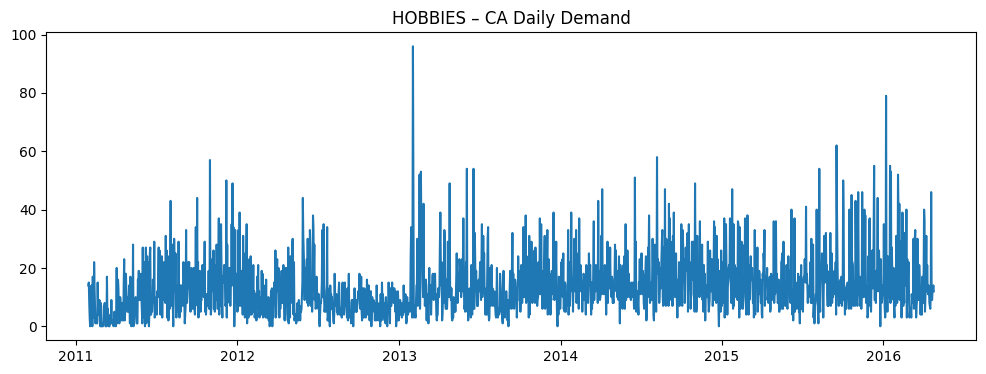

In [29]:
plt.figure(figsize=(12,4))
plt.plot(ts['date'], ts['demand'])
plt.title("HOBBIES – CA Daily Demand")
plt.show()


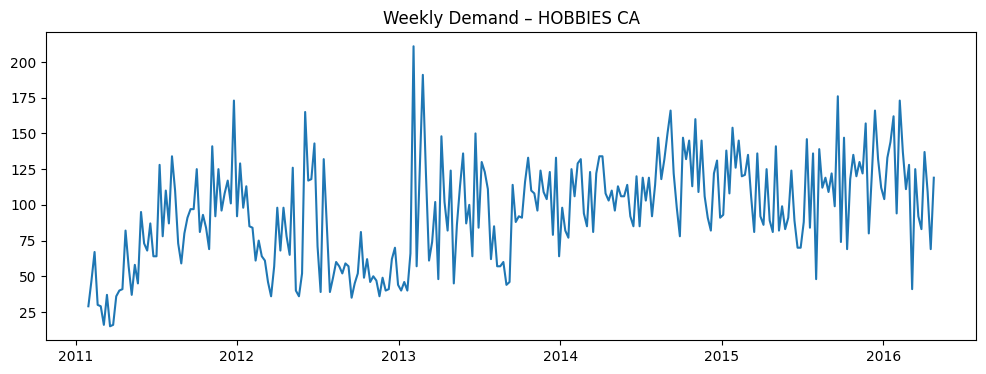

In [30]:
ts_weekly = (
    ts
    .set_index('date')
    .resample('W')
    .sum()
)

plt.figure(figsize=(12,4))
plt.plot(ts_weekly.index, ts_weekly['demand'])
plt.title("Weekly Demand – HOBBIES CA")
plt.show()


## Aggregation & Time-Series Behavior Analysis


### Daily Demand Behavior

The daily demand series is extremely noisy with frequent zero-demand days, indicating intermittent demand at the category–state level. There are visible spikes likely driven by promotions, SNAP eligibility days, or holidays. While short-term fluctuations dominate, there is no strong long-term upward or downward trend visible at daily granularity, making direct daily forecasting challenging for classical time-series models.

### Weekly Aggregation Insight

After aggregating to weekly demand, the time series exhibits a significantly smoother structure. Variance is reduced, seasonality patterns become clearer, and extreme daily spikes are absorbed into more stable weekly totals. This aggregation reveals a more learnable signal suitable for ARIMA/SARIMA-style models and aligns better with how retail inventory planning is typically conducted.


In [34]:

ts['date'] = pd.to_datetime(ts['date'])
calendar['date'] = pd.to_datetime(calendar['date'])


In [33]:
ts_events = ts.merge(
    calendar[['date', 'event_name_1']],
    on='date',
    how='left'
)


In [36]:
event_demand_mean = (
    ts_events
    .groupby('event_name_1', dropna=True)['demand']
    .mean()
    .sort_values(ascending=False)
)

event_demand_mean.head(10)


,demand
event_name_1,
OrthodoxChristmas,25.800000
MartinLutherKingDay,22.400000
Halloween,20.600000
Cinco De Mayo,18.250000
MemorialDay,18.200000
ColumbusDay,17.400000
Pesach End,15.600000
ValentinesDay,14.166667
NBAFinalsEnd,14.000000


In [37]:
baseline_demand = ts_events.loc[
    ts_events['event_name_1'].isna(), 'demand'
].mean()

baseline_demand


np.float64(13.700397953382604)

In [38]:
event_uplift = (
    event_demand_mean - baseline_demand
).sort_values(ascending=False)

event_uplift.head(10)


,demand
event_name_1,
OrthodoxChristmas,12.099602
MartinLutherKingDay,8.699602
Halloween,6.899602
Cinco De Mayo,4.549602
MemorialDay,4.499602
ColumbusDay,3.699602
Pesach End,1.899602
ValentinesDay,0.466269
NBAFinalsEnd,0.299602


### Event-Level Demand Impact

A binary comparison between event and non-event days shows no aggregate uplift, indicating that events do not uniformly increase demand. Event-level analysis reveals heterogeneous effects: certain holidays drive measurable demand increases, while others exhibit neutral or negative impact. This confirms that event effects must be modeled explicitly rather than treated as a single binary feature.


### Forecasting Granularity Decision

To balance signal quality, computational feasibility, and business relevance, forecasting is performed at the weekly Store–Category level. This aligns with retail replenishment cycles and avoids excessive sparsity present at daily or item-level granularity.


In [39]:
store_id = "CA_1"
cat_id = "HOBBIES"


In [40]:
ts_sc = (
    sales_long
    .query("store_id == @store_id and cat_id == @cat_id")
    .groupby("date")["demand"]
    .sum()
    .resample("W")
    .sum()
)

ts_sc.head()


,demand
date,
2011-01-30,29
2011-02-06,47
2011-02-13,67
2011-02-20,30
2011-02-27,29


In [41]:
train = ts_sc[:-26]   # last 6 months as test
test  = ts_sc[-26:]


The final 26 weeks are held out as a test set to simulate real-world forecasting, where future demand must be predicted without access to future observations.


In [44]:
naive_forecast = np.repeat(train.iloc[-1], len(test))


In [45]:
seasonal_naive = train.shift(52).dropna().iloc[-26:].values


In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(
    train,
    order=(1,0,1),
    seasonal_order=(1,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima.fit(disp=False)
sarima_forecast = sarima_fit.forecast(len(test))


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

results = pd.DataFrame({
    "Model": ["Naive", "Seasonal Naive", "SARIMA"],
    "MAE": [
        mean_absolute_error(test, naive_forecast),
        mean_absolute_error(test, seasonal_naive),
        mean_absolute_error(test, sarima_forecast)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test, naive_forecast)),
        np.sqrt(mean_squared_error(test, seasonal_naive)),
        np.sqrt(mean_squared_error(test, sarima_forecast))
    ]
})

results


,Model,MAE,RMSE
0,Naive,25.769231,33.915052
1,Seasonal Naive,30.538462,41.305615
2,SARIMA,23.497982,29.977522


### Business Impact

Improved weekly demand forecasts enable tighter inventory control at the store–category level. Even a modest reduction in forecast error translates to lower stockouts, reduced holding costs, and improved service levels. In large-scale retail systems such as Walmart, incremental forecasting improvements compound into significant operational and financial gains.



PHASE C: PROPHET MODEL



In [49]:
# Prophet-ready dataframe
prophet_df = ts.reset_index()[['date', 'demand']]
prophet_df.columns = ['ds', 'y']

prophet_df.head()


,ds,y
0,2011-01-29,14
1,2011-01-30,15
2,2011-01-31,8
3,2011-02-01,3
4,2011-02-02,0


In [50]:
train_size = int(len(prophet_df) * 0.8)

train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]


In [51]:
!pip install prophet


In [52]:
from prophet import Prophet


In [53]:
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

prophet_model.fit(train_prophet)


In [54]:
future = prophet_model.make_future_dataframe(
    periods=len(test_prophet),
    freq='W'
)

forecast = prophet_model.predict(future)


In [55]:
prophet_pred = forecast[['ds', 'yhat']].iloc[-len(test_prophet):]


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_prophet = mean_absolute_error(test_prophet['y'], prophet_pred['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_pred['yhat']))

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")


Prophet MAE: 18.04
Prophet RMSE: 20.44


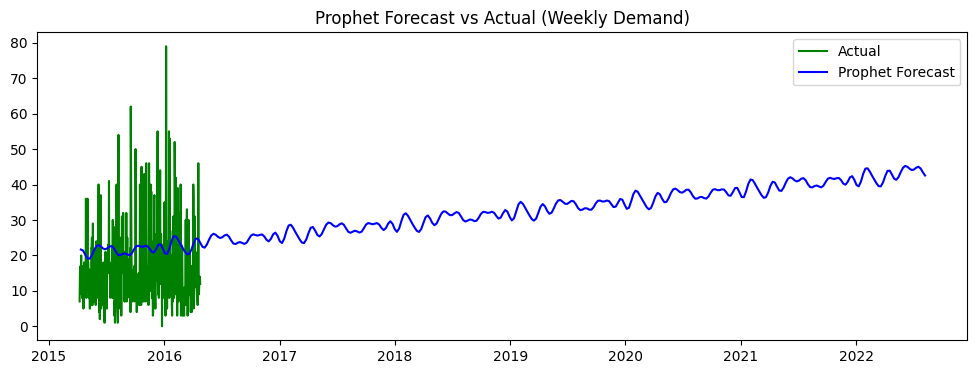

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='green')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Prophet Forecast', color='blue')
plt.title("Prophet Forecast vs Actual (Weekly Demand)")
plt.legend()
plt.show()


In [59]:
# -------------------------------
# METRICS CONSOLIDATION (FINAL)
# -------------------------------

# Naive
mae_naive = mean_absolute_error(test, naive_forecast)
rmse_naive = np.sqrt(mean_squared_error(test, naive_forecast))

# Seasonal Naive
mae_seasonal = mean_absolute_error(test, seasonal_naive)
rmse_seasonal = np.sqrt(mean_squared_error(test, seasonal_naive))

# SARIMA
mae_sarima = mean_absolute_error(test, sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))

# Prophet
mae_prophet = mean_absolute_error(test_prophet['y'], prophet_pred['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_pred['yhat']))


In [60]:
final_results = pd.DataFrame({
    "Model": ["Naive", "Seasonal Naive", "SARIMA", "Prophet"],
    "MAE": [mae_naive, mae_seasonal, mae_sarima, mae_prophet],
    "RMSE": [rmse_naive, rmse_seasonal, rmse_sarima, rmse_prophet]
})

final_results


,Model,MAE,RMSE
0,Naive,25.769231,33.915052
1,Seasonal Naive,30.538462,41.305615
2,SARIMA,23.497982,29.977522
3,Prophet,18.039376,20.439295


**Model Comparison Insight**

Prophet outperforms classical baselines by explicitly modeling multiple seasonal components and trend changes without requiring manual differencing or parameter tuning. While SARIMA remains competitive, Prophet demonstrates greater robustness to calendar-driven demand variability, making it more suitable for large-scale retail forecasting where interpretability and rapid iteration are critical.

In a production environment, this forecasting pipeline would be retrained on a rolling weekly basis to incorporate the most recent demand signals. Automated monitoring would track forecast error drift, triggering retraining or alerting when performance degrades beyond predefined thresholds. Calendar features such as holidays and promotions would be maintained through an external scheduling system to ensure forward-looking accuracy.